In [1]:
from ROOT import TH1D, TCanvas, TF1, std
from pyLCIO import EVENT, UTIL, IOIMPL, IMPL
#from UTIL import CellIDDecoder
import matplotlib.pyplot as plt
import numpy as np

Welcome to JupyROOT 6.22/00
Loading LCIO ROOT dictionaries ...


In [2]:
import math
import sys
import string


class CellIDDecoder:

    """ decoder for LCIO cellIDs """

    def __init__(self,encStr):
        self.encStr=encStr
        self.funs = {} 

        tokens = encStr.split(',')
        
        offset = 0
        
        for t in tokens:
        
         # print "token: " , t
        
          st = t.split(':')
        
          if len(st)==2:
            name = st[0]
            start = offset 
            width = int(st[1])
            offset += abs( width )
        
          elif len(st)==3:
            name = st[0]
            start = int(st[1]) 
            width = int(st[2])
            offset = start + abs( width )
        
        
          else:
            print ("unknown token:" , t)
        
          mask = int(0x0)
          for i in range(0,abs(width)):
            mask = mask | ( 0x1 << ( i + start) )
        
          setattr( CellIDDecoder , name , self.makefun( mask, start , width) )


    def makefun(self, mask,start,width):
      if( width > 0 ):
        return ( lambda ignore, cellID : (( mask & cellID) >> start )  )
      else:
        return ( lambda ignore, cellID : (~(( mask & cellID) >> start )  ^ 0xffffffff) )

In [8]:
## returns fractional energy: first 20 layers and last 10 layers
def fracEsum(fName, maxEvt):
    reader = IOIMPL.LCFactory.getInstance().createLCReader()
    reader.open( fName )
    
    esum20l = []
    esum10l = []

    
    nEvt = 0

    for evt in reader:
        nEvt += 1
        if nEvt > maxEvt:
                break
        ecalBarrel = evt.getCollection("EcalBarrelCollectionRec")
        cellIDString = ecalBarrel.getParameters().getStringVal("CellIDEncoding")
        decoder = CellIDDecoder( cellIDString ) 
        esum20 = 0.0
        esum10 = 0.0 
        for hit in ecalBarrel:
            l = decoder.layer( hit.getCellID0() ) 
            e = hit.getEnergy() 
            #print ("Energy:", hit.getEnergy(), " Cell ID0:", hit.getCellID0(), " layer: ", decoder.layer( hit.getCellID0() )) 
            if l < 20:
                esum20 += e 
            if l >= 20:
                esum10 += e 
        
        esum20l.append(esum20)
        esum10l.append(esum10)
        
    esum20np = np.asarray(esum20l)
    esum10np = np.asarray(esum10l)
    
    return esum20np, esum10np
    

In [15]:
wgan_e20, wgan_e10 = fracEsum("wgan50GeV_REC.slcio", 5000)
vgan_e20, vgan_e10 = fracEsum("vgan50GeV_REC.slcio", 5000)
bib_e20, bib_e10 = fracEsum("bibae50GeV_REC.slcio", 1000)
g4_e20, g4_e10 = fracEsum("nom50GeV_REC.slcio", 5000)

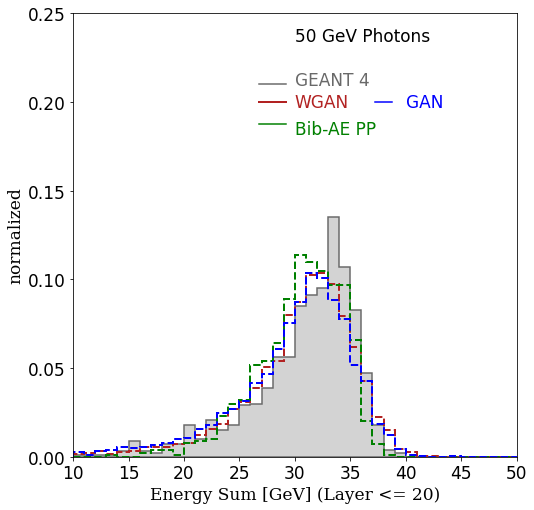

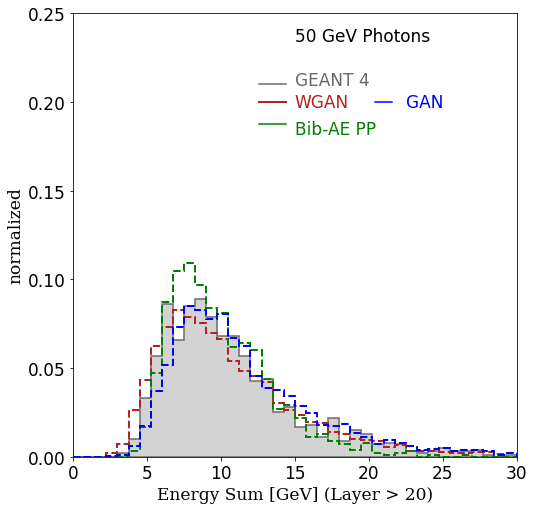

In [28]:
plt.rcParams.update({'font.size': 17})
plt_singleEnergy(g4_e20, wgan_e20, bib_e20, vgan_e20 , 50, 50, 10, bins=40, xtitle="Energy Sum [GeV] (Layer <= 20)",save_title="l20")
plt_singleEnergy(g4_e10, wgan_e10, bib_e10, vgan_e10 , 50, 30, 0, bins=40, xtitle="Energy Sum [GeV] (Layer > 20)",save_title="l10")

In [17]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
color_list = []
color_list.append('dimgrey')
color_list.append('firebrick')
color_list.append('green')
color_list.append('blue')

linewidth_list = []
linewidth_list.append(1.5)
linewidth_list.append(2)

    
linestyle_list = []
linestyle_list.append('-')
linestyle_list.append('--')

fillcolor_list = []
fillcolor_list.append('lightgrey')
fillcolor_list.append('red')

def plt_singleEnergy(data_real, data_fake, data_fake2, data_fake3, energy_center, maxE, minE, bins, xtitle,save_title):
    figSE = plt.figure(figsize=(8,8))
    axSE = figSE.add_subplot(1,1,1)
    lightblue = (0.1, 0.1, 0.9, 0.3)
    
   
    pSEa = axSE.hist(data_real, bins=bins, range=[minE, maxE], density=None, 
                   weights=np.ones_like(data_real)/(float(len(data_real))), edgecolor=color_list[0], 
                   label = "orig", linewidth=linewidth_list[0],color=fillcolor_list[0],
                   histtype='stepfilled')

    axSE.plot((0.42, 0.48),(0.84, 0.84),linewidth=linewidth_list[0], 
             linestyle=linestyle_list[0], transform=axSE.transAxes, color = color_list[0]) 
    axSE.text(0.50, 0.87, 'GEANT 4', horizontalalignment='left',verticalalignment='top', 
             transform=axSE.transAxes, color = color_list[0])


    
    pSpnEb = axSE.hist(data_fake, bins=pSEa[1], range=None, density=None, 
                   weights=np.ones_like(data_fake)/(float(len(data_fake))), edgecolor=color_list[1], 
                   label = "orig", linewidth=linewidth_list[1], linestyle=linestyle_list[1],
                   histtype='step')

    pSpnEc = axSE.hist(data_fake2, bins=pSEa[1], range=None, density=None, 
                   weights=np.ones_like(data_fake2)/(float(len(data_fake2))), edgecolor=color_list[2], 
                   label = "orig", linewidth=linewidth_list[1], linestyle=linestyle_list[1],
                   histtype='step')
    
    pSpnEc = axSE.hist(data_fake3, bins=pSEa[1], range=None, density=None, 
                   weights=np.ones_like(data_fake3)/(float(len(data_fake3))), edgecolor=color_list[3], 
                   label = "orig", linewidth=linewidth_list[1], linestyle=linestyle_list[1],
                   histtype='step')
    
    axSE.plot((0.42, 0.48),(0.80, 0.80),linewidth=linewidth_list[1], 
             linestyle=linestyle_list[0], transform=axSE.transAxes, color = color_list[1]) 
    
    
    axSE.plot((0.42, 0.48),(0.75, 0.75),linewidth=linewidth_list[0], 
                 linestyle=linestyle_list[0], transform=axSE.transAxes, color = color_list[2]) 
    
    axSE.plot((0.72, 0.68),(0.80, 0.80),linewidth=linewidth_list[0], 
                 linestyle=linestyle_list[0], transform=axSE.transAxes, color = color_list[3]) 
    
    axSE.text(0.50, 0.82, 'WGAN', horizontalalignment='left',verticalalignment='top', 
             transform=axSE.transAxes, color = color_list[1])
    
    axSE.text(0.50, 0.76, 'Bib-AE PP', horizontalalignment='left',verticalalignment='top', 
             transform=axSE.transAxes, color = color_list[2])
    axSE.text(0.75, 0.82, 'GAN', horizontalalignment='left',verticalalignment='top', 
             transform=axSE.transAxes, color = color_list[3])
    

    axSE.set_ylabel('normalized', family='serif')
    axSE.set_xlabel(xtitle, family='serif')
    axSE.set_xlim([minE, maxE])
    axSE.set_ylim([0, 0.25])

  
    #axSE.xaxis.set_minor_locator(MultipleLocator(10))
    #axSE.xaxis.set_major_locator(MultipleLocator(60))


    axSE.text(0.5,
            0.97,
            '{:d} GeV Photons'.format(energy_center), horizontalalignment='left',verticalalignment='top', 
             transform=axSE.transAxes)

    plt.subplots_adjust(left=0.18, right=0.95, top=0.95, bottom=0.18)
    #plt.yscale('log')
    figSE.patch.set_facecolor('white')

    plt.savefig(save_title+ str(energy_center)+"_single_E_dist.png")

In [3]:
### read LCIO file 
fName="wgan50GeV_REC.slcio"

reader = IOIMPL.LCFactory.getInstance().createLCReader()
reader.open( fName )

In [5]:

esum20l = []
esum10l = []

maxEvt = 10
nEvt = 0

for evt in reader:
    nEvt += 1
    if nEvt > maxEvt:
            break

    ecalBarrel = evt.getCollection("EcalBarrelCollectionRec")
    cellIDString = ecalBarrel.getParameters().getStringVal("CellIDEncoding")
    decoder = CellIDDecoder( cellIDString ) 
    esum20 = 0.0
    esum10 = 0.0 
    for hit in ecalBarrel:
        l = decoder.layer( hit.getCellID0() ) 
        e = hit.getEnergy() 
        #print ("Energy:", hit.getEnergy(), " Cell ID0:", hit.getCellID0(), " layer: ", decoder.layer( hit.getCellID0() )) 
        if l < 20:
            esum20 += e 
        if l >= 20:
            esum10 += e 
        
    esum20l.append(esum20)
    esum10l.append(esum10)

In [6]:
esum10l

[10.103932661470026,
 13.481522606685758,
 14.73399115446955,
 9.25342078693211,
 12.871115502435714,
 9.764866176061332,
 8.573994510341436,
 5.616496492642909,
 17.547136172652245,
 7.820764928124845]

In [7]:
esum20l

[35.642287358874455,
 27.1752847568132,
 24.122934525366873,
 34.567480197642,
 31.96417605644092,
 29.120427996385843,
 32.66754336701706,
 34.93255496304482,
 24.277007003314793,
 30.831205948721617]